In [75]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import geopandas as gpd
import geoplot as gplt
from shapely.geometry import Point
import geoplot.crs as gcrs
import contextily as cx
import plotly.express as px
from geopandas.tools import overlay

In [92]:
# Kept the original dataset
listingsNYC = pd.read_csv('listings.csv', dtype=object)

# Dropping all of the columns which we will not use
listingsNYC= listingsNYC.drop(['last_review','license','host_name'], axis=1)

# Dropping all rows with any 'Nan' values in them
listingsNYC.dropna(axis=0, how='any', inplace=True)
data_types_dict = {
    'price':'int64', 
    'minimum_nights':'int64', 
    'host_id':str,
    'number_of_reviews':'int64',
    'reviews_per_month':float,
    'calculated_host_listings_count':'int64',
    'availability_365':'int64',
    'number_of_reviews_ltm':'int64',
    'latitude':float,
    'longitude':float,
    
}

#changing all the datatype to their respective types that we can work with
listingsNYC = listingsNYC.astype(data_types_dict)

# creating a price per stay (ppn) column with the price and minimim nights columns and rounding to 2 decimal places. 
# This is a float dtype 
listingsNYC['pps'] = (listingsNYC['price'] * listingsNYC['minimum_nights']).round(2)
listingsNYC = listingsNYC[(listingsNYC['price'] != 0)]
listingsNYC.loc[:,'log_price']=np.log(listingsNYC['price'])
listingsNYC

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,pps,log_price
0,5136,"Spacious Brooklyn Duplex, Patio + Garden",7378,Brooklyn,Sunset Park,40.662650,-73.994540,Entire home/apt,275,21,3,0.03,1,267,1,5775,5.616771
1,5203,Cozy Clean Guest Room - Family Apt,7490,Manhattan,Upper West Side,40.803800,-73.967510,Private room,75,2,118,0.73,1,0,0,150,4.317488
2,5121,BlissArtsSpace!,7356,Brooklyn,Bedford-Stuyvesant,40.685350,-73.955120,Private room,60,30,50,0.30,2,322,0,1800,4.094345
3,5178,Large Furnished Room Near B'way,8967,Manhattan,Midtown,40.764570,-73.983170,Private room,68,2,559,3.38,1,79,50,136,4.219508
4,2595,Skylit Midtown Castle,2845,Manhattan,Midtown,40.753560,-73.985590,Entire home/apt,175,30,49,0.31,3,365,1,5250,5.164786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41139,769580756557673403,Cozy 1 bedroom with 2 full beds ROOM #2,162927656,Queens,Jamaica,40.693422,-73.804985,Shared room,99,1,1,1.00,7,174,1,99,4.595120
41160,769612968972941927,Comfortable 1 bedroom ROOM #3,162927656,Queens,Jamaica,40.691520,-73.805300,Shared room,91,1,1,1.00,7,174,1,91,4.510860
41175,770593748958588679,Luxury Brooklyn apt. | 10 mins away from JFK,489532090,Brooklyn,East New York,40.666019,-73.857968,Entire home/apt,145,1,2,2.00,1,351,2,145,4.976734
41218,769850569510129629,Private Bed Manhattan 20 Mins,324722741,Queens,Woodside,40.746040,-73.909110,Private room,50,1,1,1.00,1,240,1,50,3.912023


In [95]:
neighborhood_counts = listingsNYC.groupby('neighbourhood').count()
neighborhood_counts=neighborhood_counts[['id']]
neighborhood_counts.rename(columns={'id':'neighborhood_count'}, inplace=True)
neighborhood_means = listingsNYC.groupby('neighbourhood').mean()
neighborhood_means=neighborhood_means[['latitude','longitude','price']]
neighborhood_means_and_counts= pd.merge(neighborhood_counts,neighborhood_means, on='neighbourhood')
top_20=neighborhood_means_and_counts.sort_values(by='neighborhood_count',ascending=False)

In [96]:
nyc_map = gpd.read_file("neighbourhoods.geojson")
nyc_map.crs
nyc_map= nyc_map.merge(top_20, on='neighbourhood', how='inner')
nyc_map=nyc_map[nyc_map['price']<3000]


In [97]:
nyc_map.to_crs(epsg=3857, inplace=True)

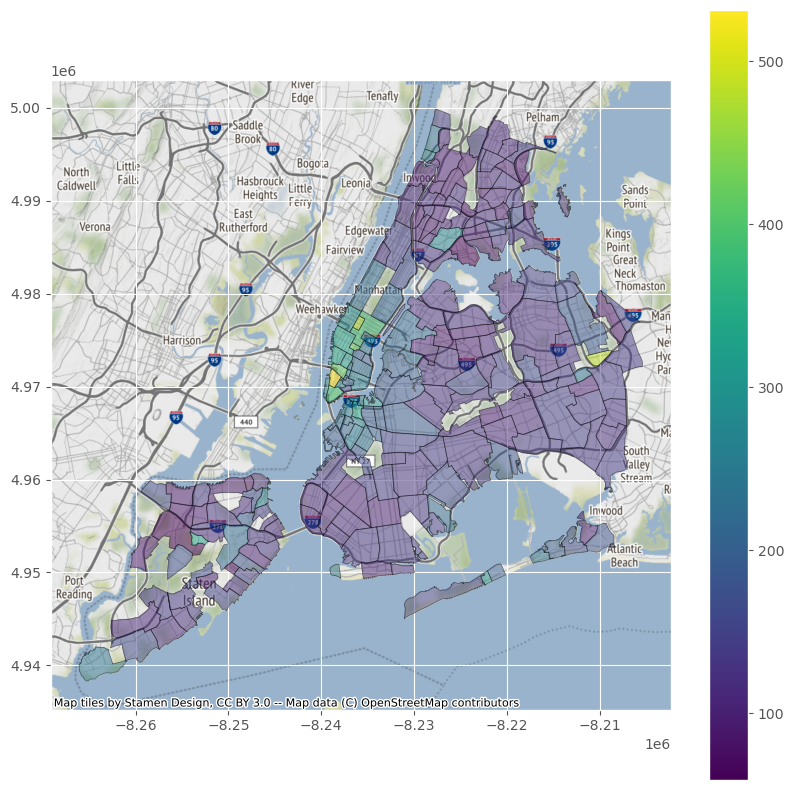

In [98]:
ax=nyc_map.plot('price',figsize=(10, 10), alpha=0.5, edgecolor='k', legend=True)
cx.add_basemap(ax)